In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the JSON file
import json
import pandas as pd

# Path to the JSON file in Google Drive
file_path = '/content/drive/My Drive/news.article.json'

# Load the JSON file
with open(file_path, 'r') as file:
    articles = json.load(file)

# Step 3: Convert to DataFrame for easier manipulation
df = pd.DataFrame(articles)

Mounted at /content/drive


In [2]:
df.head()

,articleBody,dateModified,scrapedDate,source,title
0,"Sanjay Raut, a member of the Shiv Sena (UBT) p...",{'$date': '2023-10-25T06:35:50.000Z'},{'$date': '2023-10-27T13:12:18.339Z'},https://www.thehansindia.com/,Shiv Sena MP Sanjay Raut Responds To 'Hamas' R...
1,"Kozhikode (Kerala) [India], October 27 (ANI): ...",NaN,{'$date': '2023-10-27T13:12:45.595Z'},https://www.aninews.in/,At IUML's pro-Palestine rally in Kerala Tharoo...
2,"Mumbai, Oct 24 (PTI) Maharashtra Chief Ministe...",{'$date': '2023-10-25T02:14:27.000Z'},{'$date': '2023-10-27T13:12:18.339Z'},https://thefederal.com/,Uddhav buried Bal Thackeray's 'Hindutva' for p...
3,"Sensex, Nifty rebound over 1 pc after six sess...",NaN,{'$date': '2023-10-27T13:12:41.618Z'},https://english.varthabharati.in/,"New Bills replacing IPC, CrPC, Evidence Act wi..."
4,"October 26, 2023 08:15 pm | Updated 08:38 pm I...",{'$date': '2023-10-26T14:45:24.000Z'},{'$date': '2023-10-27T13:12:45.595Z'},https://www.thehindu.com/,"Israel biggest terrorist nation in the world, ..."


In [3]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

df['cleaned_text'] = df['articleBody'].apply(clean_text)


In [4]:
def filter_relevant_articles(text):
    keywords = ['Israel', 'Hamas', 'Gaza', 'Palestine', 'war']
    return any(keyword.lower() in text.lower() for keyword in keywords)

df['is_relevant'] = df['cleaned_text'].apply(filter_relevant_articles)
relevant_articles = df[df['is_relevant']]


In [5]:
relevant_articles.head()

,articleBody,dateModified,scrapedDate,source,title,cleaned_text,is_relevant
0,"Sanjay Raut, a member of the Shiv Sena (UBT) p...",{'$date': '2023-10-25T06:35:50.000Z'},{'$date': '2023-10-27T13:12:18.339Z'},https://www.thehansindia.com/,Shiv Sena MP Sanjay Raut Responds To 'Hamas' R...,Sanjay Raut a member of the Shiv Sena UBT part...,True
1,"Kozhikode (Kerala) [India], October 27 (ANI): ...",NaN,{'$date': '2023-10-27T13:12:45.595Z'},https://www.aninews.in/,At IUML's pro-Palestine rally in Kerala Tharoo...,Kozhikode Kerala India October 27 ANI Pointing...,True
2,"Mumbai, Oct 24 (PTI) Maharashtra Chief Ministe...",{'$date': '2023-10-25T02:14:27.000Z'},{'$date': '2023-10-27T13:12:18.339Z'},https://thefederal.com/,Uddhav buried Bal Thackeray's 'Hindutva' for p...,Mumbai Oct 24 PTI Maharashtra Chief Minister E...,True
3,"Sensex, Nifty rebound over 1 pc after six sess...",NaN,{'$date': '2023-10-27T13:12:41.618Z'},https://english.varthabharati.in/,"New Bills replacing IPC, CrPC, Evidence Act wi...",Sensex Nifty rebound over 1 pc after six sessi...,True
4,"October 26, 2023 08:15 pm | Updated 08:38 pm I...",{'$date': '2023-10-26T14:45:24.000Z'},{'$date': '2023-10-27T13:12:45.595Z'},https://www.thehindu.com/,"Israel biggest terrorist nation in the world, ...",October 26 2023 0815 pm Updated 0838 pm IST ...,True


In [6]:
import spacy
from dateutil.parser import parse

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_dates(text):
    doc = nlp(text)
    dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    return dates

relevant_articles['dates'] = relevant_articles['cleaned_text'].apply(extract_dates)


<ipython-input-6-e2651087d89f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_articles['dates'] = relevant_articles['cleaned_text'].apply(extract_dates)


In [8]:
def extract_events(text):
    sentences = text.split('.')
    return sentences

relevant_articles['events'] = relevant_articles['cleaned_text'].apply(extract_events)


<ipython-input-8-de7d644c4893>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_articles['events'] = relevant_articles['cleaned_text'].apply(extract_events)


In [12]:
from collections import defaultdict
from dateutil.parser import parse

event_dict = defaultdict(list)

for _, row in relevant_articles.iterrows():
    for date in row['dates']:
        try:
            parsed_date = parse(date, fuzzy=True)
            for event in row['events']:
                event_dict[parsed_date.date()].append(event)
        except Exception as e:
            print(f"Error parsing date: {e}")
            continue


Streaming output truncated to the last 5000 lines.
Error parsing date: month must be in 1..12: 20232024
Error parsing date: second must be in 0..59: the 1970s
Error parsing date: String does not contain a date: today
Error parsing date: String does not contain a date: Less than a decade later
Error parsing date: String does not contain a date: A few years
Error parsing date: String does not contain a date: less than three years later
Error parsing date: String does not contain a date: Just weeks
Error parsing date: String does not contain a date: weeks
Error parsing date: String does not contain a date: two weeks
Error parsing date: String does not contain a date: just a week
Error parsing date: String does not contain a date: the many months
Error parsing date: String does not contain a date: weeks later
Error parsing date: String does not contain a date: decades
Error parsing date: String does not contain a date: years
Error parsing date: String does not contain a date: this month
Er

In [13]:
def summarize_events(events):
    return ' '.join(events[:5])  # Take the first 5 events as a simple summary

summarized_events = {date: summarize_events(events) for date, events in event_dict.items()}


In [15]:
print(f"Number of dates: {len(dates)}")
print(f"Number of events: {len(events)}")
print("Sample dates:", dates[:5])
print("Sample events:", events[:5])


Number of dates: 20
Number of events: 20
Sample dates: [datetime.date(2024, 6, 12), datetime.date(2024, 6, 11), datetime.date(1990, 6, 9), datetime.date(2024, 10, 27), datetime.date(2024, 10, 7)]
Sample events: ['Sanjay Raut a member of the Shiv Sena UBT party responded to the Maharashtra chief ministers statement that Eknath Shinde himself is Hamas and that the Shiv Sena group led by Uddhav Thackeray is capable of collaborating with Hamas and LashkareTaiba for their own selfishness on Wednesday by claiming that Eknath Shinde is Hamas Raut made fun of Shinde by claiming He himself is Hamas Hamas and LashkareTaiba two terrorist groups are completely irrelevant in Maharashtra But the BJP is to blame for sowing the worms in their the Shinde factions thoughts said Raut When Shinde made a statement at the Tuesday Dussehra rally in Mumbais Azad Maidan Raut reacted to it As part of the opposition alliance INDIA Uddhav Thackerays Shiv Sena UBT has formed an alliance with Congress and the Samaj

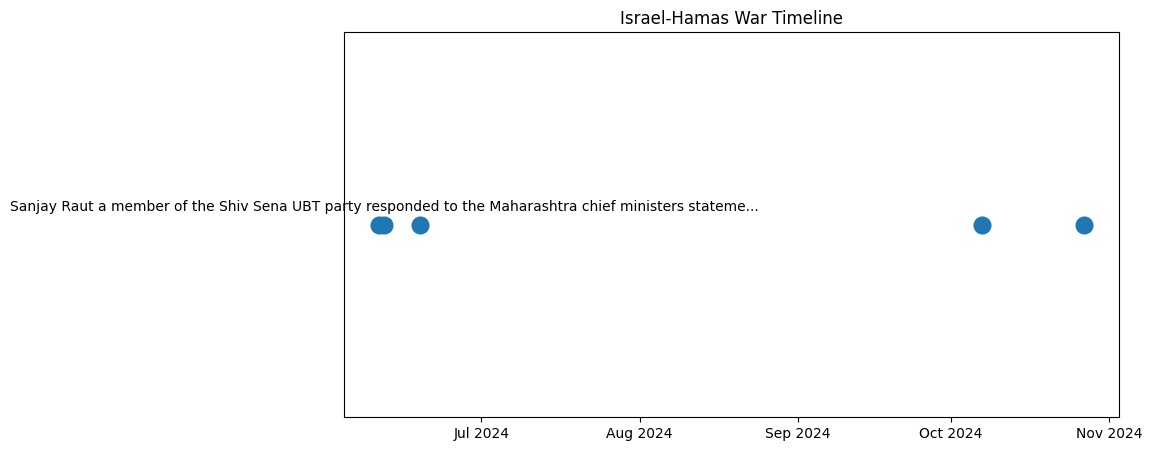

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to truncate long text
def truncate_text(text, max_length=100):
    return (text[:max_length] + '...') if len(text) > max_length else text

# Truncate the events
truncated_events = [truncate_text(event) for event in events]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot_date(dates, [1] * len(dates), markersize=12)

for date, event in zip(dates, truncated_events):
    plt.annotate(event, (mdates.date2num(date), 1), textcoords="offset points", xytext=(0, 10), ha='center')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().yaxis.set_visible(False)

plt.title('Israel-Hamas War Timeline')
plt.show()
